In [1]:
# Datenzugriff
from configs.path_manager import get_path
import pickle

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.analysis_basics import check_constrains as check

# Solver Model
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*20     # 20 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

scheduling_type = "simple"

## Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
experiments_data_path = get_path("data", "experiments")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


In [5]:
day_length = 1440

execution_dict = {}

# Tag 1

In [6]:
day_numb = 1

In [7]:
df_schedule = pd.read_csv(experiments_data_path / f"CP_{day_numb:02d}_schedule.csv")
df_schedule

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


In [8]:
df_execution = pd.read_csv(experiments_data_path / "CP_01_execution.csv")
execution_dict[day_numb] = df_execution
df_execution

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,0,M00,1568.0,84.0,1652.0
1,J25-0000,8,79,1,M01,1833.0,67.0,1900.0
2,J25-0000,8,79,2,M03,2286.0,67.0,2353.0
3,J25-0000,8,79,3,M05,2464.0,50.0,2514.0
4,J25-0000,8,79,4,M02,2514.0,69.0,2583.0
5,J25-0000,8,79,5,M09,2680.0,12.0,2692.0
...,...,...,...,...,...,...,...,...
134,J25-0015,5,1436,3,M03,1810.0,72.0,1882.0
135,J25-0015,5,1436,4,M08,2014.0,54.0,2068.0
136,J25-0015,5,1436,5,M09,2068.0,59.0,2127.0


In [9]:
# Simulation "wiederherstellen"
with open(experiments_data_path / "CP_01_active_dict.pkl", "rb") as f:
   active_dict = pickle.load(f)

simulation.set_active_operations(active_dict)

In [10]:
df_active = pd.read_csv(experiments_data_path / "CP_01_active.csv")
df_active

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,8,J25-0000,8,M04,79,2873.0,26,26.0,2899.0,2899.0
1,3,J25-0004,5,M08,287,2844.0,52,52.0,2896.0,2896.0
2,7,J25-0009,8,M07,1004,2873.0,36,33.0,2909.0,2906.0


In [11]:
df_not_started = pd.read_csv(experiments_data_path / "CP_01_not_started.csv")
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
1,J25-0002,0,198,1440,3744,9,M09,3723,21,3744
2,J25-0003,2,243,1440,3379,9,M04,3346,33,3379
3,J25-0004,3,287,1440,4856,6,M07,2981,85,3066
4,J25-0004,3,287,1440,4856,7,M03,3066,98,3164
5,J25-0004,3,287,1440,4856,8,M09,3164,22,3186
...,...,...,...,...,...,...,...,...,...,...
11,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
12,J25-0010,0,1025,1440,3345,9,M09,3324,21,3345
13,J25-0011,1,1030,1440,3210,9,M08,3180,30,3210


## Tag 2 - 5

Tag 02: [2880, 4320)

Solver-Status         : OPTIMAL
Objective Value       : 35.00
Best Objective Bound  : 35.00
Laufzeit              : 0.26 Sekunden


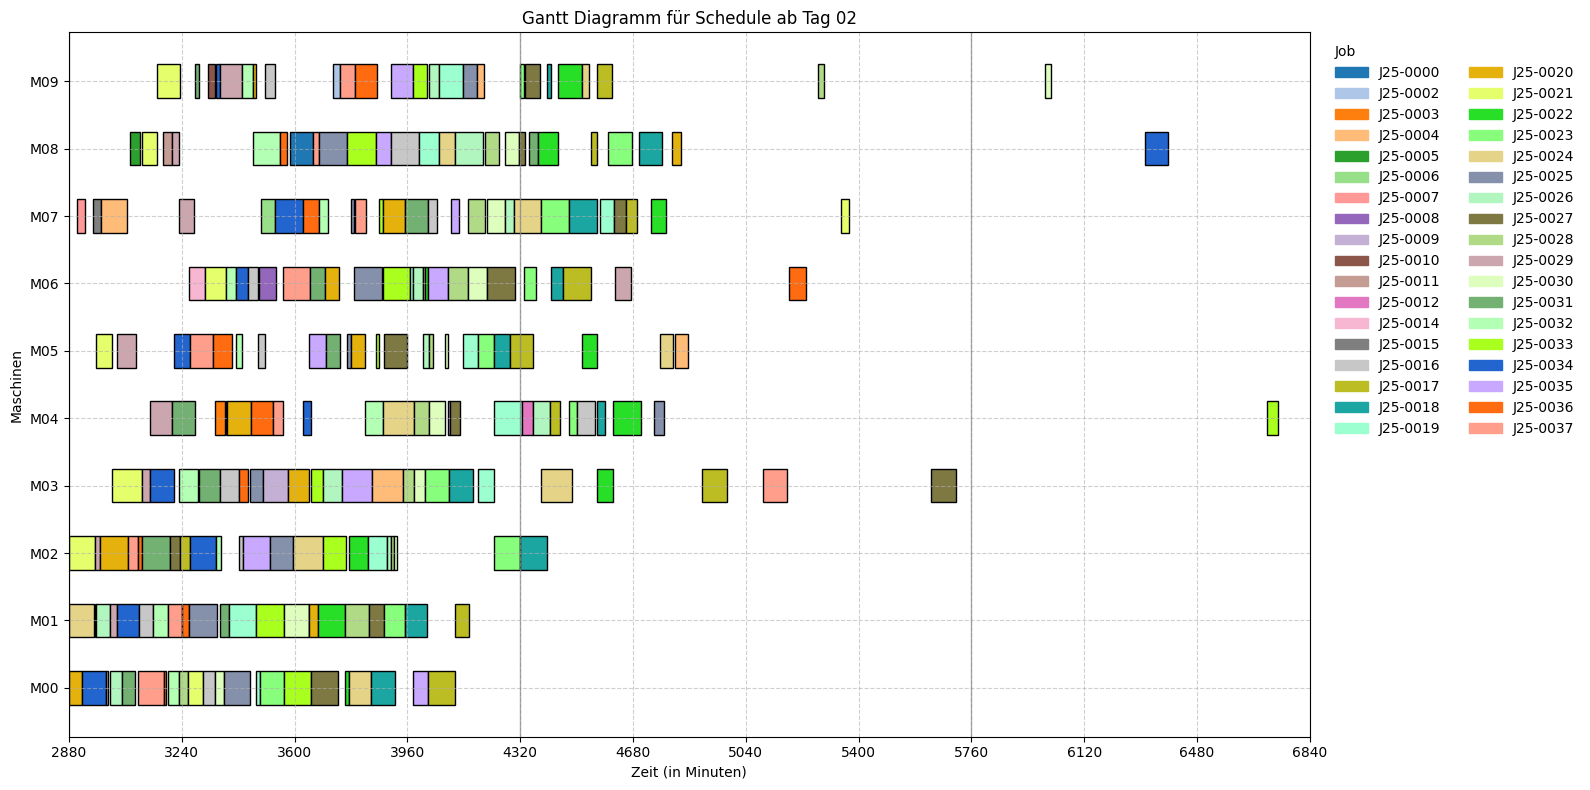

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

Remaining time: 16.0
Start time: 2880
End time: 2896.0
[Day 2 00:00:00] Job J25-0004, Operation 5 resumed on M08 (with 16 minutes left)
Remaining time: 26.0
Start time: 2880
End time: 2906.0
[Day 2 00:00:00] Job J25-0009, Operation 8 resumed on M07 (with 26 minutes left)
Remaining time: 19.0
Start time: 2880
End time: 2899.0
[Day 2 00:00:00] Job J25-0000, Operation 8 resumed on M04 (with 19 minutes left)
[Day 2 00:00:00] Job J25-0020 started on M00
[Day 2 00:00:00] Job J25-0021 started on M02
[Day 2 00:00:00] Job J25-0024 started on M01
[Day 2 00:16:00] Job J25-0004 finished on M08 (after 16 minutes)
[Day 2 00:19:00] Job J25-0000 finished on M04 (after 19 minutes)
[Day 2 00:26:00] Job J25-0009 finished on M07 (after 26 minutes)
[Day 2 00

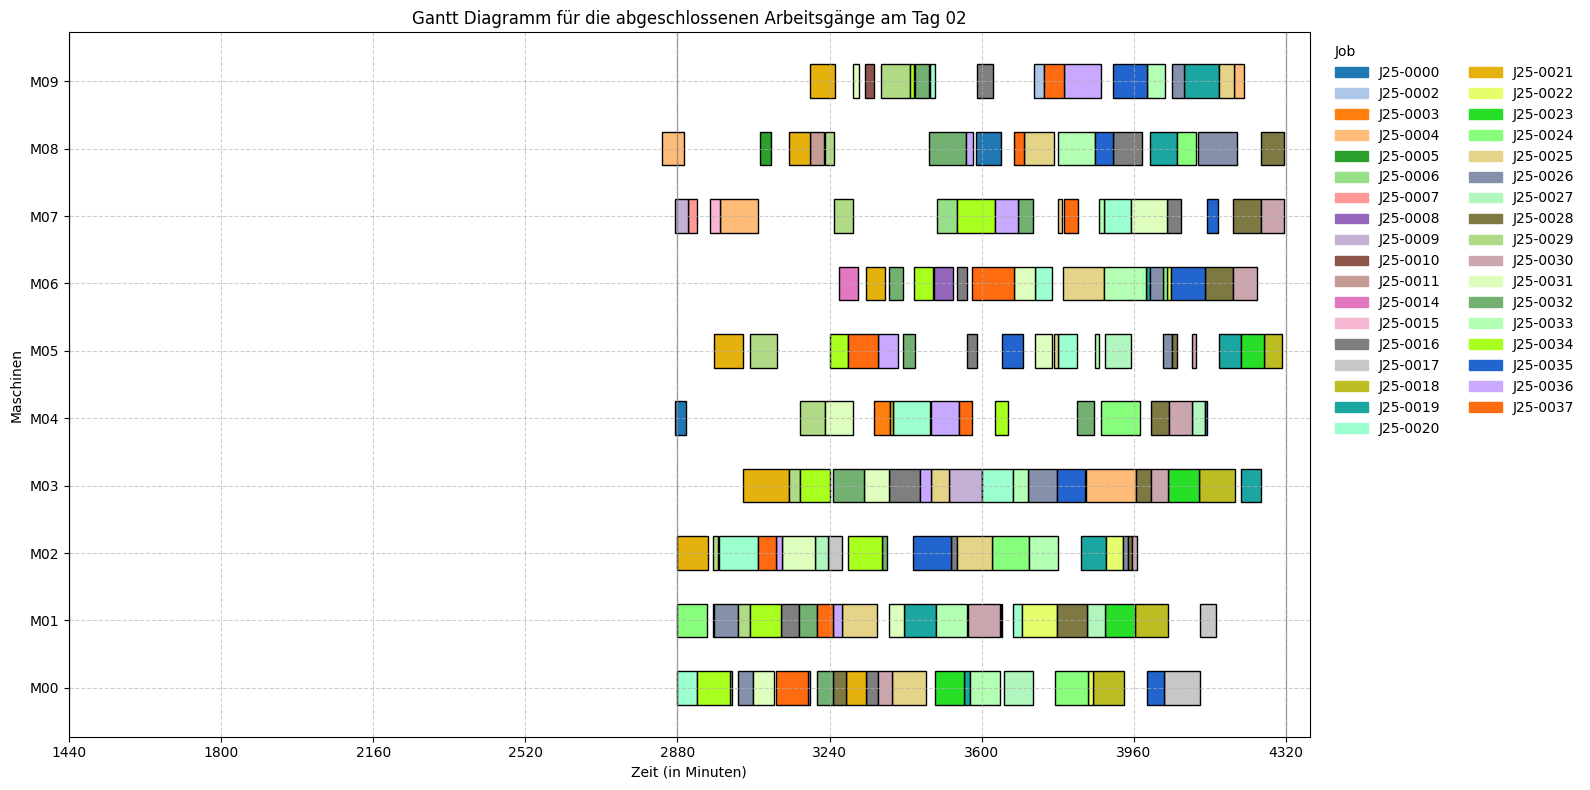

Tag 03: [4320, 5760)

Solver-Status         : OPTIMAL
Objective Value       : 3614.00
Best Objective Bound  : 3545.00
Laufzeit              : 342.27 Sekunden


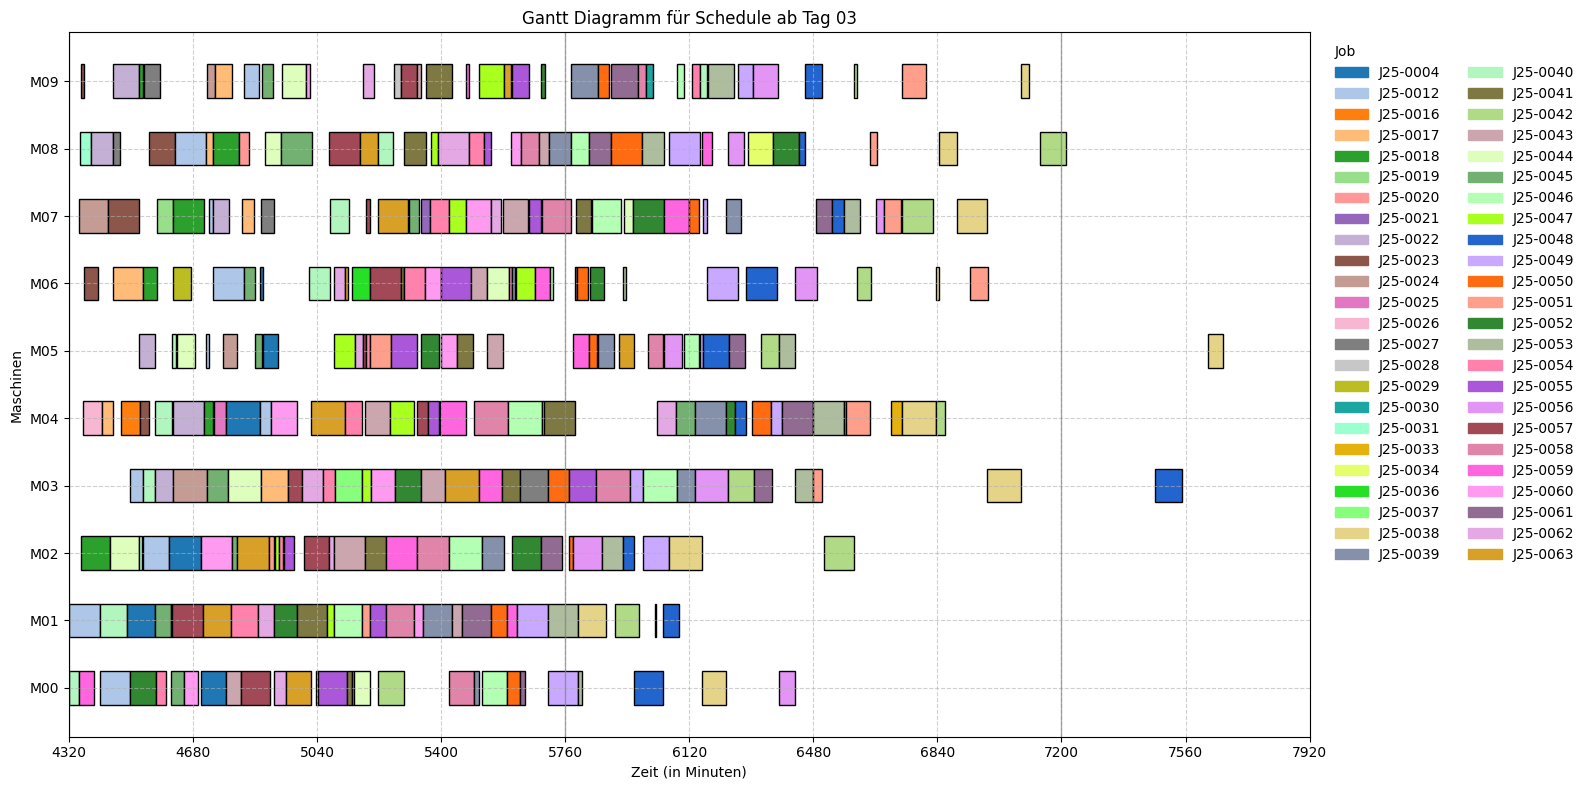

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

Remaining time: 21.0
Start time: 4320
End time: 4341.0
[Day 3 00:00:00] Job J25-0027, Operation 5 resumed on M06 (with 21 minutes left)
Remaining time: 18.0
Start time: 4320
End time: 4338.0
[Day 3 00:00:00] Job J25-0019, Operation 8 resumed on M04 (with 18 minutes left)
Remaining time: 34.0
Start time: 4320
End time: 4354.0
[Day 3 00:00:00] Job J25-0023, Operation 4 resumed on M02 (with 34 minutes left)
Remaining time: 72.0
Start time: 4320
End time: 4392.0
[Day 3 00:00:00] Job J25-0017, Operation 3 resumed on M05 (with 72 minutes left)
Remaining time: 29.0
Start time: 4320
End time: 4349.0
[Day 3 00:00:00] Job J25-0026, Operation 8 resumed on M07 (with 29 minutes left)
Remaining time: 33.0
Start time: 4320
End time: 4353.0
[Day 3 00:00

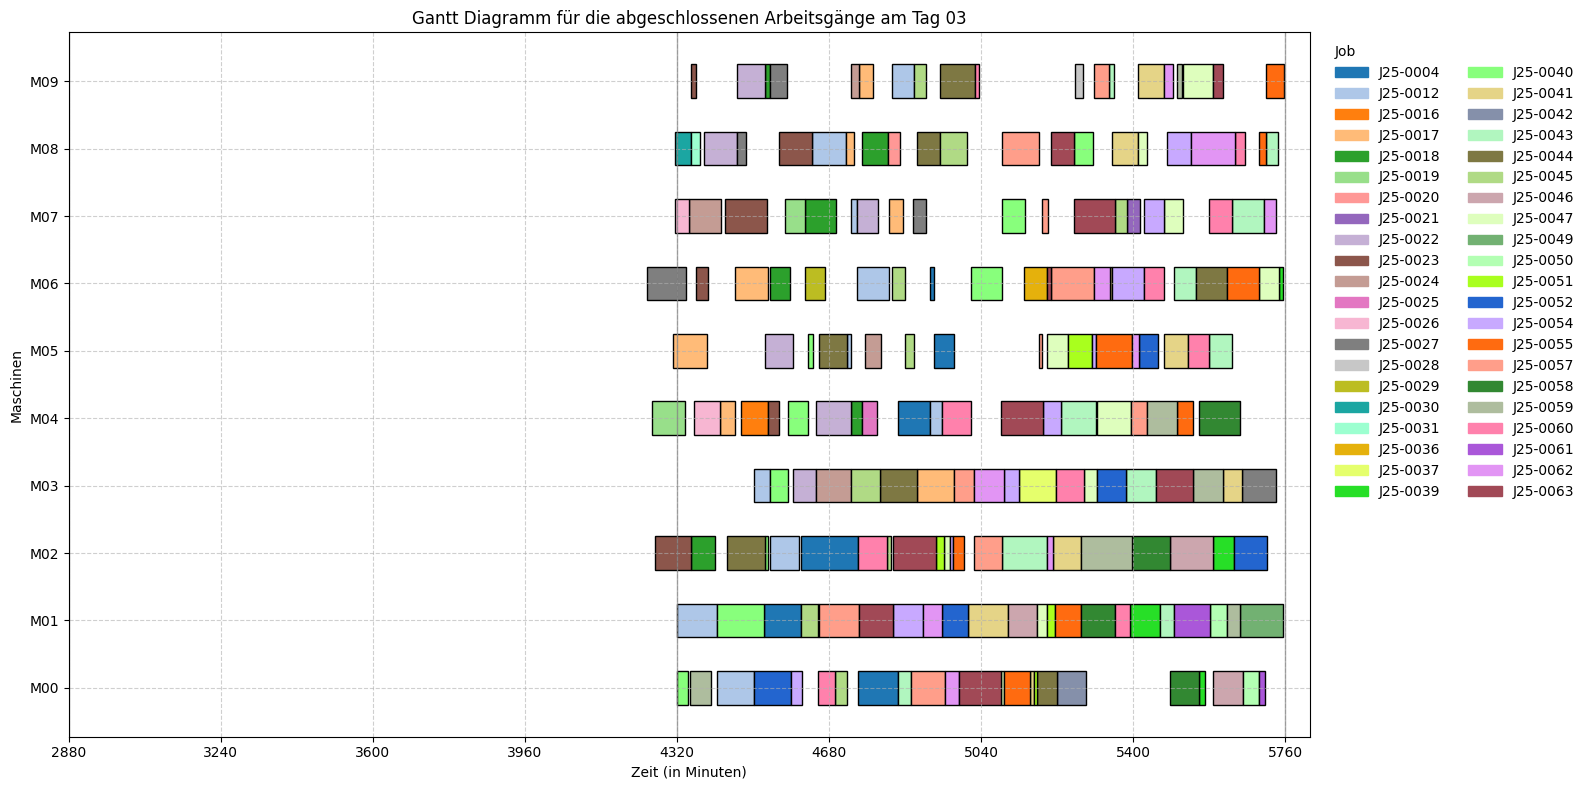

Tag 04: [5760, 7200)

Solver-Status         : FEASIBLE
Objective Value       : 14731.00
Best Objective Bound  : 6950.00
Laufzeit              : 1200.58 Sekunden


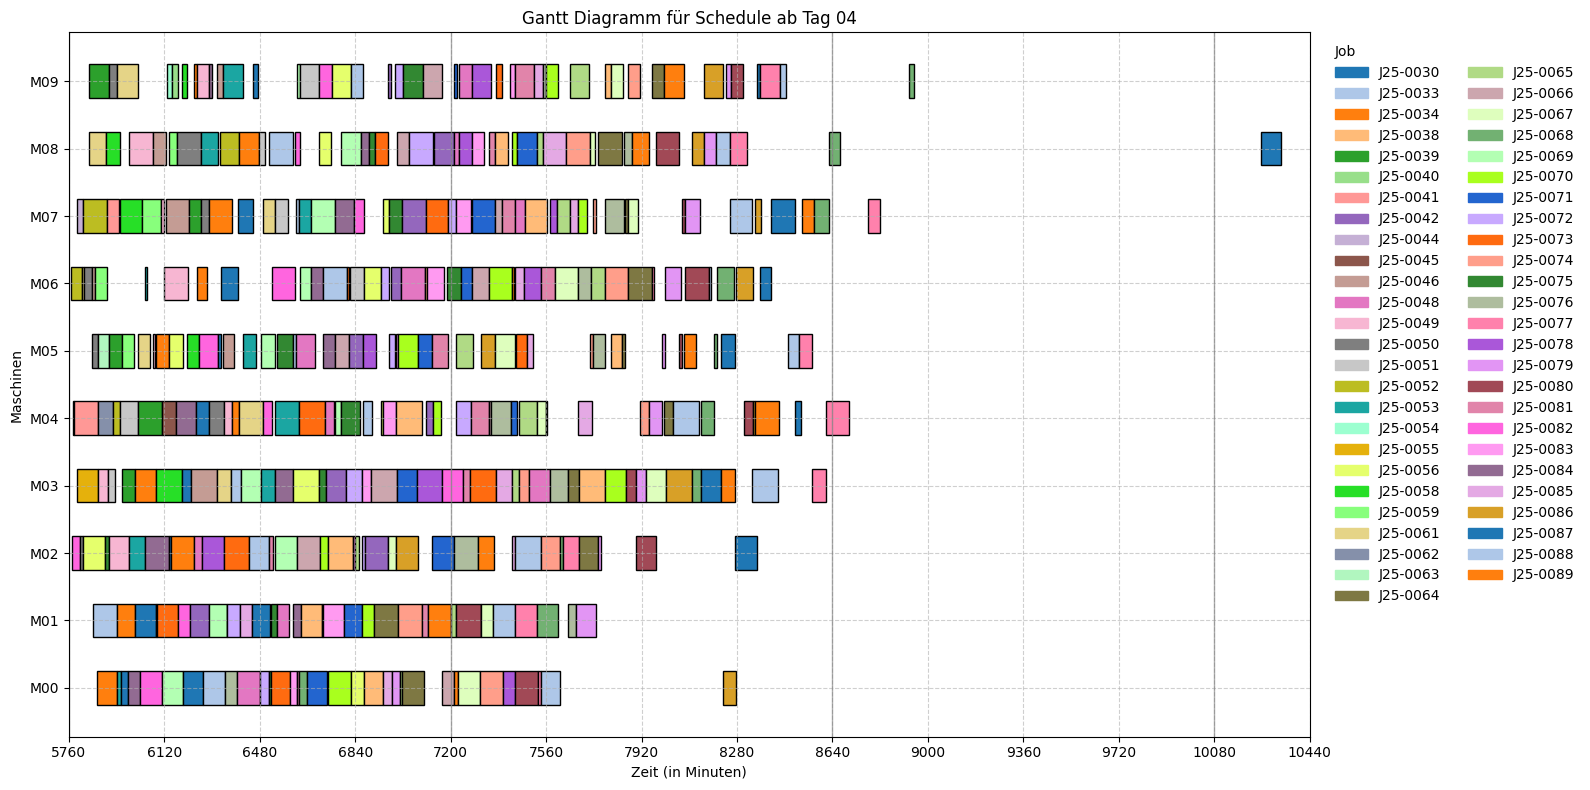

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

Remaining time: 14.0
Start time: 5760
End time: 5774.0
[Day 4 00:00:00] Job J25-0046, Operation 3 resumed on M04 (with 14 minutes left)
Remaining time: 10.0
Start time: 5760
End time: 5770.0
[Day 4 00:00:00] Job J25-0061, Operation 2 resumed on M02 (with 10 minutes left)
Remaining time: 30.0
Start time: 5760
End time: 5790.0
[Day 4 00:00:00] Job J25-0050, Operation 2 resumed on M03 (with 30 minutes left)
Remaining time: 3.0
Start time: 5760
End time: 5763.0
[Day 4 00:00:00] Job J25-0058, Operation 4 resumed on M06 (with 03 minutes left)
Remaining time: 75.0
Start time: 5760
End time: 5835.0
[Day 4 00:00:00] Job J25-0039, Operation 4 resumed on M08 (with 75 minutes left)
Remaining time: 91.0
Start time: 5760
End time: 5851.0
[Day 4 00:00:

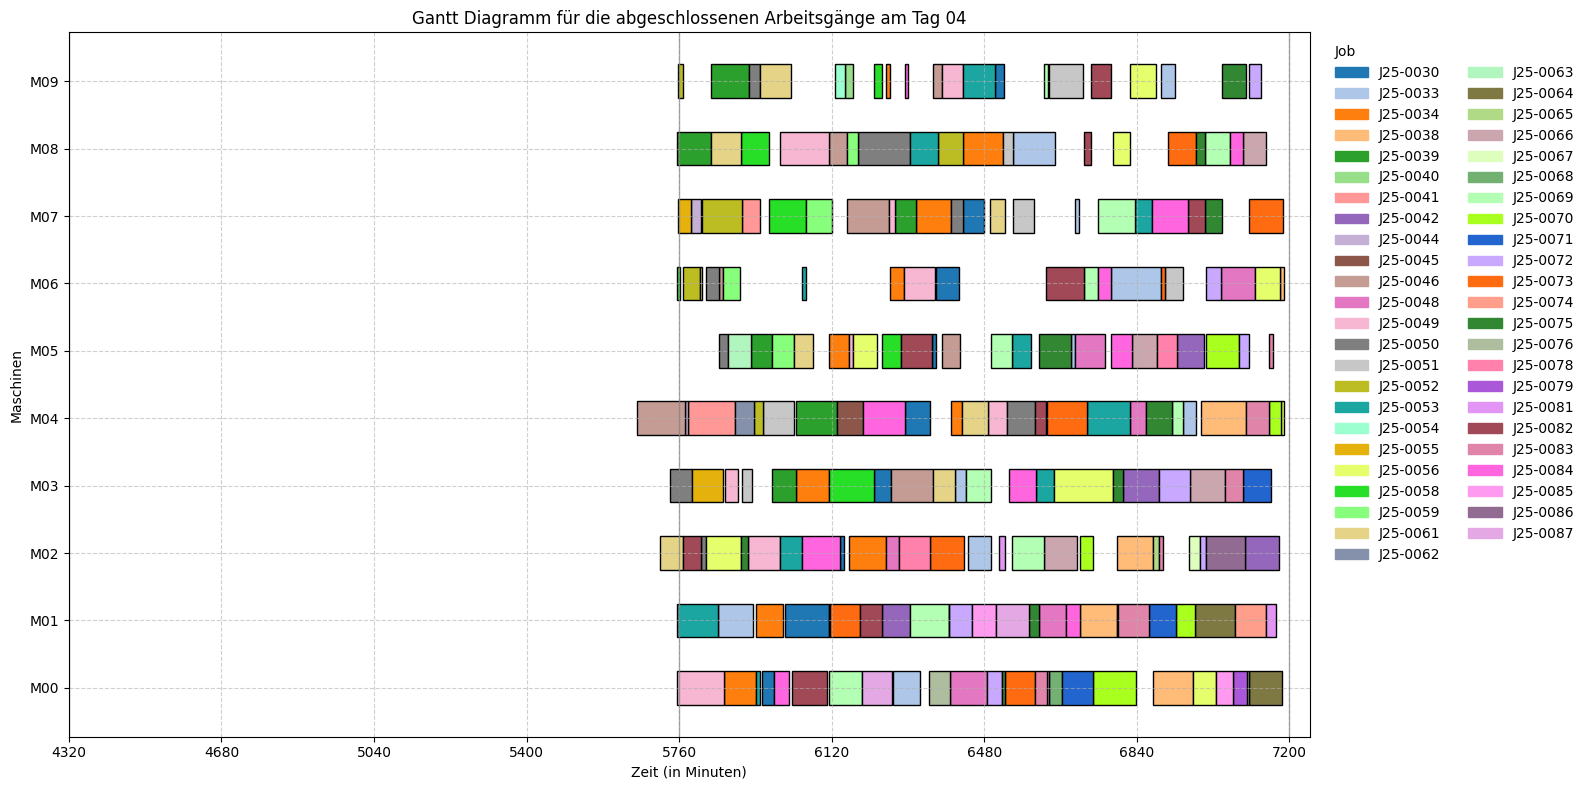

Tag 05: [7200, 8640)

Solver-Status         : FEASIBLE
Objective Value       : 18747.00
Best Objective Bound  : 11368.00
Laufzeit              : 1200.56 Sekunden


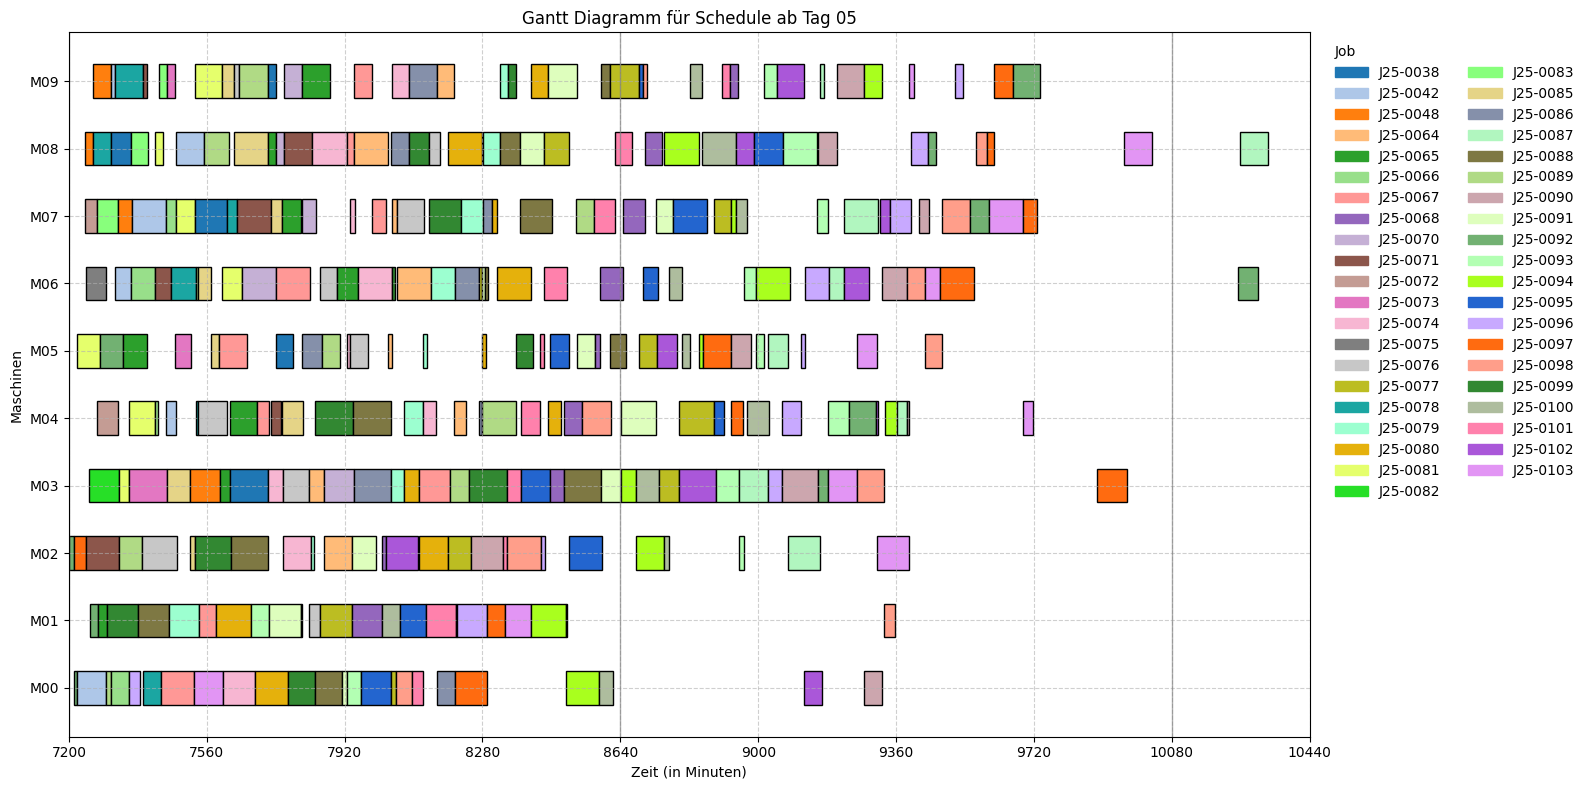

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

Remaining time: 43.0
Start time: 7200
End time: 7243.0
[Day 5 00:00:00] Job J25-0072, Operation 7 resumed on M08 (with 43 minutes left)
Remaining time: 16.0
Start time: 7200
End time: 7216.0
[Day 5 00:00:00] Job J25-0066, Operation 5 resumed on M09 (with 16 minutes left)
Remaining time: 52.0
Start time: 7200
End time: 7252.0
[Day 5 00:00:00] Job J25-0078, Operation 3 resumed on M03 (with 52 minutes left)
Remaining time: 20.0
Start time: 7200
End time: 7220.0
[Day 5 00:00:00] Job J25-0071, Operation 3 resumed on M05 (with 20 minutes left)
Remaining time: 55.0
Start time: 7200
End time: 7255.0
[Day 5 00:00:00] Job J25-0089, Operation 0 resumed on M01 (with 55 minutes left)
Remaining time: 44.0
Start time: 7200
End time: 7244.0
[Day 5 00:00

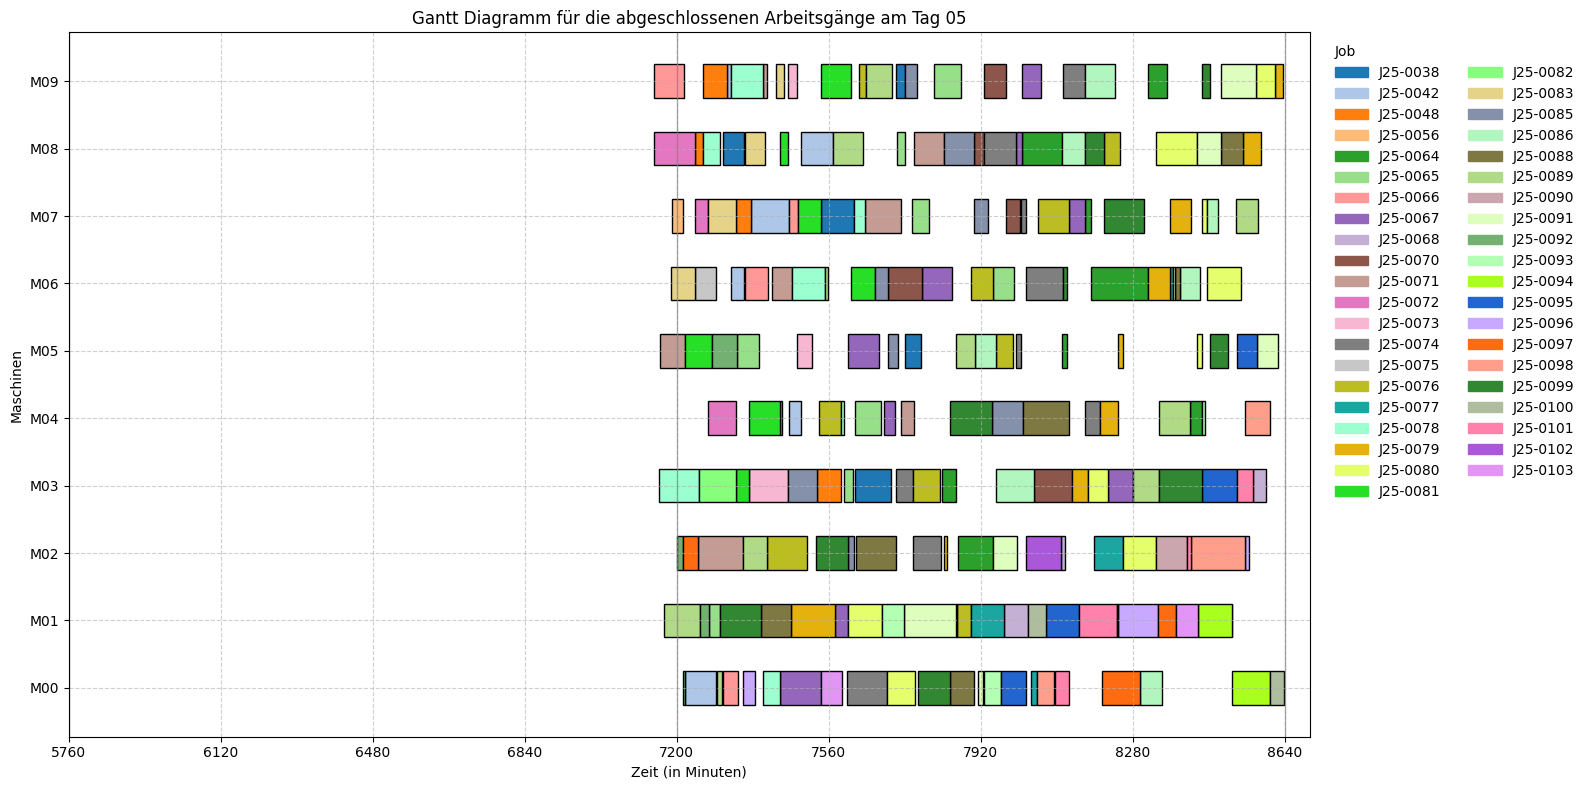

In [12]:
first_start = 2
last_planning_start = 5

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

    df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)

    df_jssp_current = filter_current_jssp(
       df_jssp=df_jssp,
       df_jobs_times_current=df_jobs_times_current,
       exclusion_dataframes_list=[df_active, df_execution]
    )

    # --- Scheduling ---
    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(
        df_jssp_current, df_jobs_times_current, df_active,
        reschedule_start = day_start, w_t = 5,
        msg=False, timeLimit=max_time, gapRel= 0.02
    )

    df_schedule.to_csv(experiments_data_path / f"CP_{day_numb:02d}_schedule_{scheduling_type}.csv", index=False)
    gantt.get_plot(df_schedule, perspective="Machine", title=f"Gantt Diagramm für Schedule ab Tag {day_numb:02d}")
    check.all_in_one(df_schedule)

    # --- Simulation ---
    simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

    df_execution = simulation.get_finished_operations_df()
    gantt.get_plot(df_execution, perspective="Machine", title=f"Gantt Diagramm für die abgeschlossenen Arbeitsgänge am Tag {day_numb:02d}")

    df_active = simulation.get_active_operations_df()
    df_not_started = simulation.get_not_started_operations_df(df_schedule)

    # Extra
    execution_dict[day_numb] = df_execution

